In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import psycopg2
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style = 'darkgrid')

In [3]:
con = psycopg2.connect(dbname='mimic', user='sudarshan', host='/var/run/postgresql')

In [4]:
query = """
select count(*) as n_notes, count(distinct hadm_id) as n_adms from data group by chartinterval order by chartinterval;
"""

df = pd.read_sql_query(query, con)
intervals = ['0 < t < 12', '12 < t < 24', '24 < t < 36', '36 < t < 48', '48 < t < 60', '60 < t < 72', '72 < t < 84', '84 < t < 96', '96 < t < 108', '108 < t < 120', '120 < t 132', '132 < t < 144', '144 < t < 156', '156 < t < 168', '168 < t < 180', 't > 180']
df['hours'] = intervals

mdf = df.copy()
mdf.rename(columns={'n_adms':'Number of Admissions', 'n_notes':'Number of Notes'}, inplace=True)
mdf = pd.melt(mdf, id_vars='hours', var_name='Legend', value_name='counts')

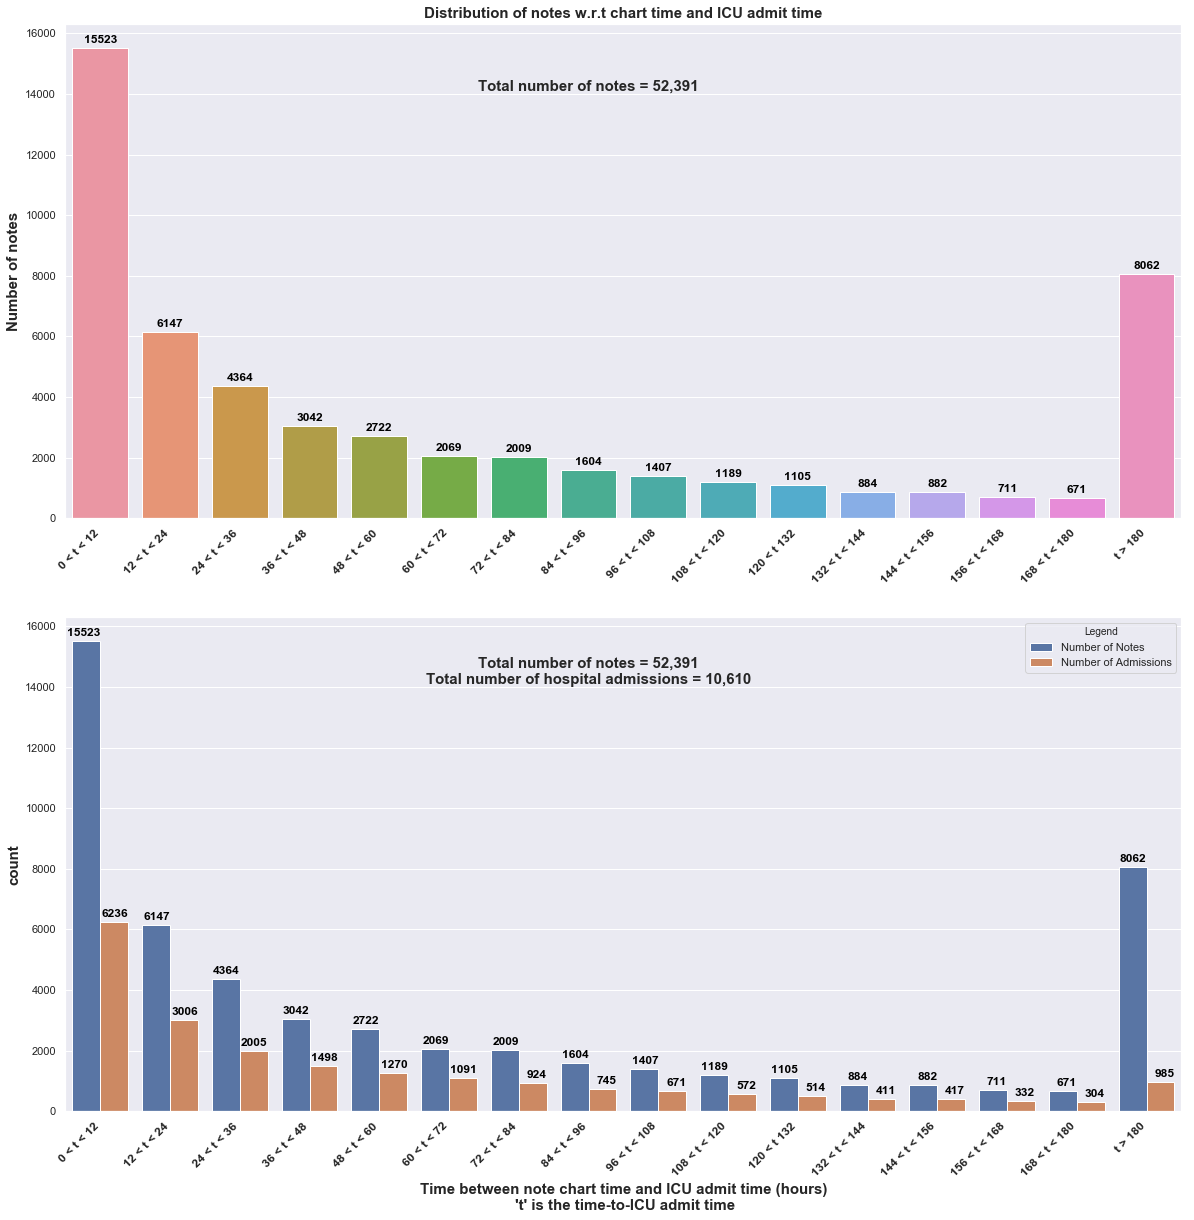

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.barplot(x='hours', y='n_notes', data=df, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=45, ha='right', fontweight='bold', fontsize=12)
ax[0].set_xlabel("")
ax[0].set_ylabel('Number of notes', fontweight='bold', fontsize=15)
ax[0].set_title('Distribution of notes w.r.t chart time and ICU admit time', fontweight='bold', fontsize=15)

ax[0].text(7, 14000, 'Total number of notes = 52,391', fontweight='bold', fontsize=15, ha='center', va='bottom')

for index, row in df.iterrows():
    ax[0].text(index, row['n_notes'] + 100, str(row['n_notes']), color='black', ha='center', va='bottom', fontweight='bold', fontsize=12)

sns.barplot(x='hours', y='counts', hue='Legend', data=mdf, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=45, ha='right', fontweight='bold', fontsize=12)
ax[1].set_xlabel("Time between note chart time and ICU admit time (hours)\n 't' is the time-to-ICU admit time", fontweight='bold', fontsize=15)
ax[1].set_ylabel('count', fontweight='bold', fontsize=15)

ax[1].text(7, 14000, 'Total number of notes = 52,391\nTotal number of hospital admissions = 10,610', fontweight='bold', fontsize=15, ha='center', va='bottom')

for index, row in mdf.iterrows():
    if index < 16:
        ax[1].text(index, row['counts']+100, str(row['counts']), color='black', ha='right', va='bottom', fontweight='bold', fontsize=12)
    else:
        ax[1].text(index % 16 + 0.4, row['counts']+100, str(row['counts']), color='black', ha='right', va='bottom', fontweight='bold', fontsize=12)

In [6]:
query = """
select hadm_id, count(*) as n_notes from data group by hadm_id order by hadm_id;
"""
df = pd.read_sql_query(query, con)
df.head()

,hadm_id,n_notes
0,100009,2
1,100012,2
2,100018,8
3,100020,16
4,100021,6


Text(20, 4500, 'Total number of hospital admissions = 10,610')

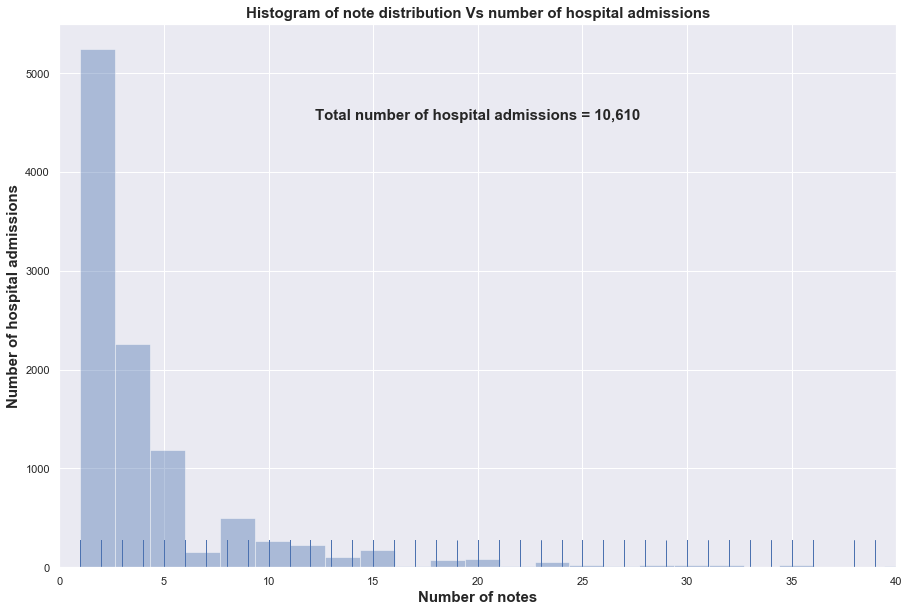

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.distplot(df['n_notes'], kde=False, ax=ax, rug=True, bins=100)
ax.set_xlabel('Number of notes', fontweight='bold', fontsize=15)
ax.set_ylabel('Number of hospital admissions', fontweight='bold', fontsize=15)
ax.set_title('Histogram of note distribution Vs number of hospital admissions', fontweight='bold', fontsize=15)
ax.set_ylim(0, 5500)
ax.set_xlim(0, 40)

ax.text(20, 4500, 'Total number of hospital admissions = 10,610', fontweight='bold', fontsize=15, ha='center', va='bottom')

In [8]:
query = """
select hadm_id, avg(wait_period) as avg_wait_period from data group by hadm_id order by hadm_id;
"""
df = pd.read_sql_query(query, con)
df.head()

,hadm_id,avg_wait_period
0,100009,18.38
1,100012,47.07
2,100018,6.44
3,100020,21.22
4,100021,105.13


In [9]:
df['avg_wait_period'].min(), df['avg_wait_period'].mean(), df['avg_wait_period'].max()

(0.01, 86.84440716305372, 3269.1)

Text(300, 3000, 'Total number of hospital admissions = 10,610')

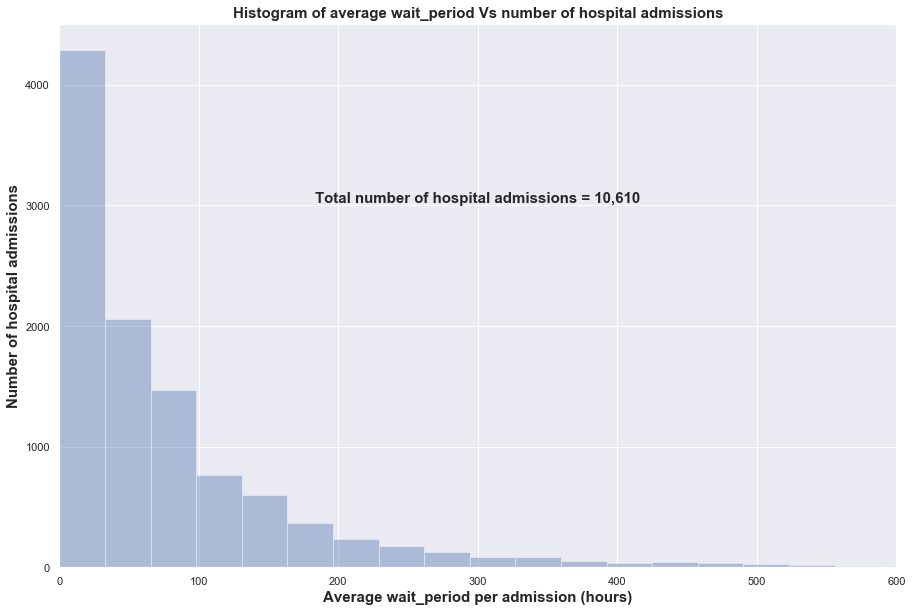

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.distplot(df['avg_wait_period'], kde=False, ax=ax, bins=100)
ax.set_xlabel('Average wait_period per admission (hours)', fontweight='bold', fontsize=15)
ax.set_ylabel('Number of hospital admissions', fontweight='bold', fontsize=15)
ax.set_title('Histogram of average wait_period Vs number of hospital admissions', fontweight='bold', fontsize=15)
ax.set_xlim(0, 600)

ax.text(300, 3000, 'Total number of hospital admissions = 10,610', fontweight='bold', fontsize=15, ha='center', va='bottom')

In [11]:
query = """
with test as (select subject_id, count(distinct hadm_id) as n_adms from data group by subject_id order by subject_id) select n_adms, count(*) from test group by n_adms order by n_adms;
"""
df = pd.read_sql_query(query, con)
df.head()

,n_adms,count
0,1,9209
1,2,571
2,3,67
3,4,12
4,5,2


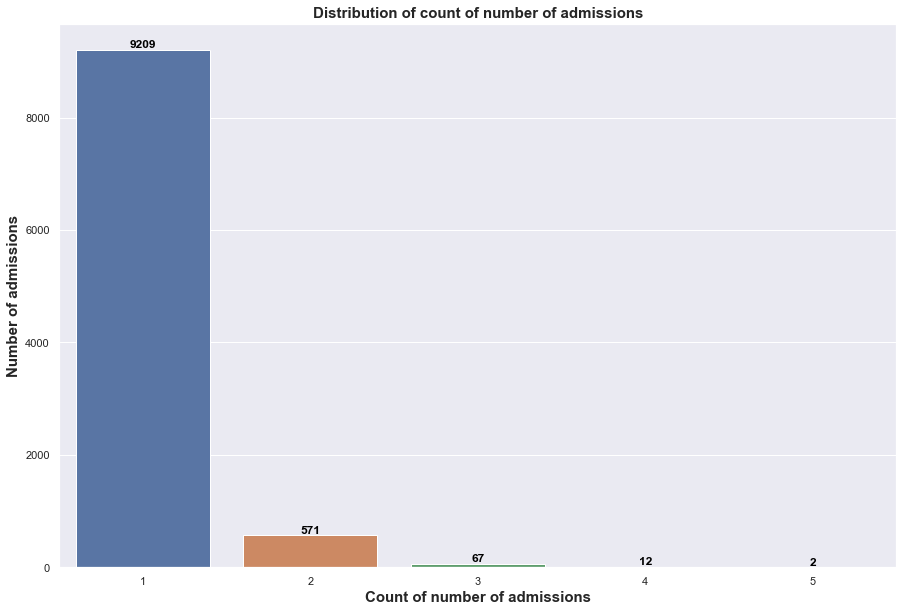

In [12]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x='n_adms', y='count', data=df, ax=ax)
ax.set_xlabel("Count of number of admissions", fontweight='bold', fontsize=15)
ax.set_ylabel('Number of admissions', fontweight='bold', fontsize=15)
ax.set_title('Distribution of count of number of admissions', fontweight='bold', fontsize=15)
for index, row in df.iterrows():
    ax.text(index, row['count'], str(row['count']), color='black', ha='center', va='bottom', fontweight='bold', fontsize=12)

In [13]:
query = """
select length(text) as note_length from data;
"""
df = pd.read_sql_query(query, con)
df.head()

,note_length
0,1623
1,1327
2,1611
3,1095
4,846


In [14]:
df['note_length'].min(), df['note_length'].mean(), df['note_length'].max()

(57, 1837.7011127865474, 20155)

Text(5000, 8000, 'Total number of notes = 52391\nmin = 57, average = 1837.70, max = 20155')

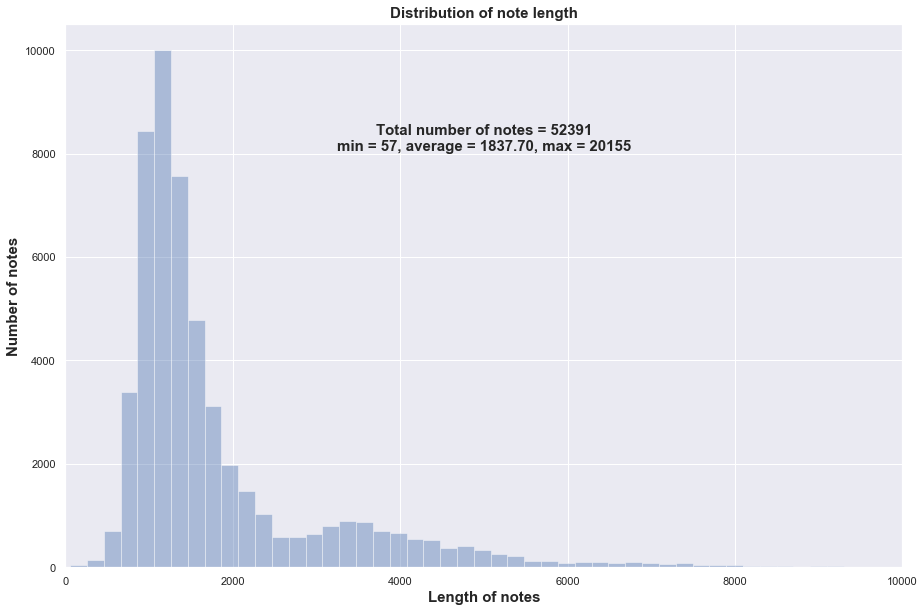

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.distplot(df['note_length'], kde=False, ax=ax, bins=100)
ax.set_xlabel('Length of notes', fontweight='bold', fontsize=15)
ax.set_ylabel('Number of notes', fontweight='bold', fontsize=15)
ax.set_title('Distribution of note length', fontweight='bold', fontsize=15)
ax.set_xlim(0, 10000)

ax.text(5000, 8000, f"Total number of notes = {len(df)}\nmin = {df['note_length'].min()}, average = {df['note_length'].mean():0.2f}, max = {df['note_length'].max()}", fontweight='bold', fontsize=15, ha='center', va='bottom')

In [16]:
con.close()